In [1]:
"""
The goal of this code is to provide a good offensive identity for every NBA player. It does so via KMeans and Spectral Clustering.
The NBA's play-type data provides a lot of information we can use to cluster together players.

Why is this valuable:
(1) From the perspective of the front office, it provides a great deal of statistical information on what other players on the market
may be able to fill in a hole created by a player leaving in free agency
(2) From the perspective of the coaching staff, it creates a frame of reference for the situations in which a player is best used

"""

"\nThe goal of this code is to provide a good offensive identity for every NBA player. It does so via techniques from unsupervised learning.\nThe NBA's play-type data provides a lot of information we can use to cluster together players.\n\nWhy is this valuable:\n(1) From the perspective of the front office, it provides a great deal of statistical information on what other players on the market\nmay be able to fill in a hole created by a player leaving in free agency\n(2) From the perspective of the coaching staff, it creates a frame of reference for the situations in which a player is best used\n(3) \n"

In [ ]:
"""
Latest update:

clustering isn't working well, primarily for two reasons:
(1) Way too many variables
(2) No solution as to how to handle players who do not engage in a certain play type enough for their stats to be recorded. 
My attempt to solve the first problem will be to separate the algorithm from one large cluster, to clustering individually within each play type
"""

In [2]:
#Mathematical tools
import matplotlib.pyplot as plt
from kneed import KneeLocator
import numpy as np
import pandas as pd
from functools import reduce
import seaborn as sns

In [3]:
#Machine learning tools
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [4]:
#Read data into dataframe
raw_data = {}
raw_data["isolation"] = pd.read_csv("isolation.csv")
raw_data["cut"] = pd.read_csv("cut.csv")
raw_data["off_screen"] = pd.read_csv("OffScreen.csv")
raw_data["PnR_handler"] = pd.read_csv("PandRBallHandler.csv")
raw_data["PnR_roller"] = pd.read_csv("PandRRoller.csv")
raw_data["post_up"] = pd.read_csv("PostUp.csv")
raw_data["spot_up"] = pd.read_csv("SpotUp.csv")

#Getting rid of an NaN row, as well as team
for type in raw_data.keys():
    raw_data[type] = raw_data[type].drop([0, 0])
    raw_data[type] = raw_data[type].drop(columns=["TEAM"])
    
    column_names = []
    for stat in raw_data[type].columns:
        column_names.append(stat + "_" + type)

    raw_data[type].columns = column_names
        

In [5]:
#Merge the dataframes
unfiltered_inputs = raw_data["isolation"]
for key in raw_data.keys():
    if key != "isolation":
        unfiltered_inputs = unfiltered_inputs.merge(raw_data[key], left_on="PLAYER_isolation", right_on=("PLAYER_" + key), how="outer")
        print(len(unfiltered_inputs))
        
#Drop the player names
player_names = unfiltered_inputs["PLAYER_isolation"]
unfiltered_inputs = unfiltered_inputs.drop(columns=[name for name in unfiltered_inputs.columns if "PLAYER" in name])

#Replace unmatched NaN with zeroes
for column in unfiltered_inputs.columns:
    unfiltered_inputs[column] = unfiltered_inputs[column].fillna(0.0)
no_player_column_names = unfiltered_inputs.columns

140
168
256
326
352
546


In [7]:
#Let's bring everything to the same scale before clustering.
no_processing_inputs = unfiltered_inputs
unfiltered_inputs = pd.DataFrame(StandardScaler().fit_transform(unfiltered_inputs))
unfiltered_inputs = pd.DataFrame(normalize(unfiltered_inputs))
unfiltered_inputs.columns = no_player_column_names

In [8]:
"""
Let's start with k-means clustering. Before we fully train, we need to determine the best number of clusters.
"""

"\nLet's start with k-means clustering. Before we fully train, we need to determine the best number of clusters.\n"

/Users/nehalchigurupati/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nehalchigurupati/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nehalchigurupati/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nehalchigurupati/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: 

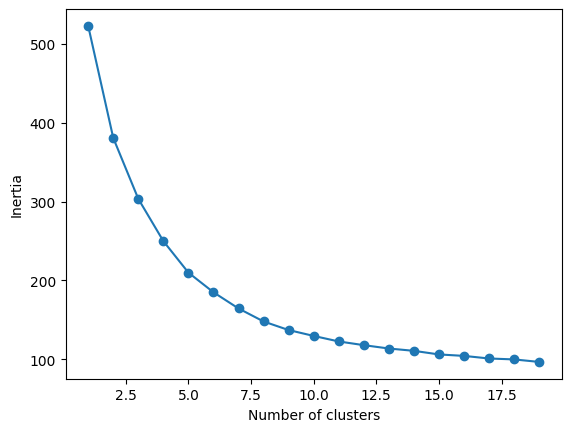

In [9]:

inertias = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(unfiltered_inputs)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 20), inertias, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

/Users/nehalchigurupati/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nehalchigurupati/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nehalchigurupati/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nehalchigurupati/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: 

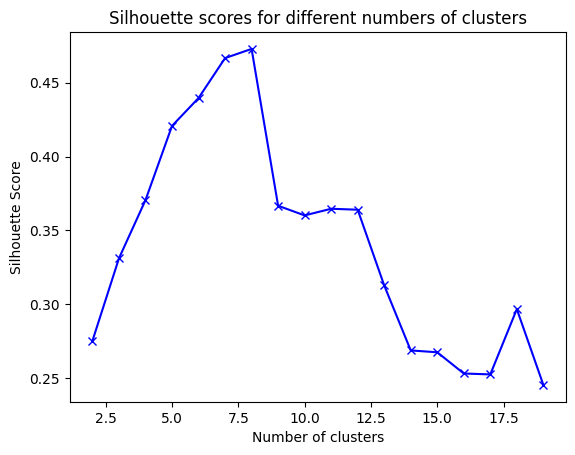

In [10]:
#From the above plot, the elbow occurs at 7 clusters. Let's confirm this is proper with silhouette analysis.
silhouette_avg = []
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(unfiltered_inputs)
    cluster_labels = kmeans.labels_

    silhouette_avg.append(silhouette_score(unfiltered_inputs, cluster_labels))

plt.plot(range(2, 20), silhouette_avg, 'bx-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette scores for different numbers of clusters")
plt.show()


In [11]:
#The silhouette analysis confirms that 7 clusters is optimal. Lets train on that. 
kmeans = KMeans(n_clusters=7)
kmeans.fit(unfiltered_inputs)

labels = pd.DataFrame(kmeans.labels_)
filtered_output = pd.concat((unfiltered_inputs, labels), axis=1)
filtered_output = filtered_output.rename({0:"labels"},axis=1)

/Users/nehalchigurupati/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [12]:
#Next, let's visualize the projection of the clusters in the feature space into 2-space

In [13]:
filtered_output["Constant"] = ["Data"]*len(filtered_output)

<Axes: xlabel='Constant', ylabel='PPP_PnR_handler'>

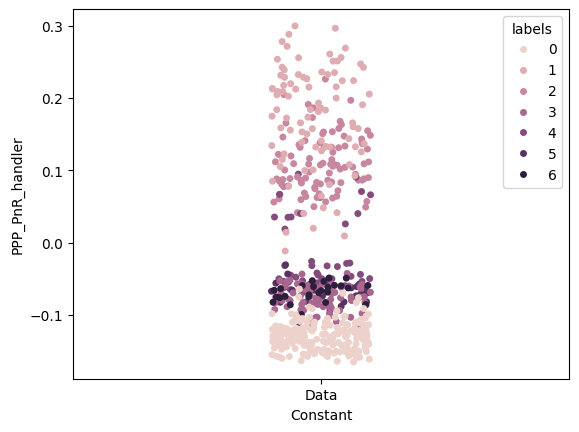

In [14]:
sns.stripplot(x=filtered_output['Constant'], y=filtered_output["PPP_PnR_handler"], hue=filtered_output['labels'], jitter=True)

In [15]:
"""
Implicit in the analysis above is that the data is spherical, but perhaps that is too strong an assumption.
In this case, spectral clustering would be a better technique. 
Let's try that.
"""

"\nImplicit in the analysis above is that the data is spherical, but perhaps that is too strong an assumption.\nIn this case, spectral clustering would be a better technique. \nLet's try that.\n"

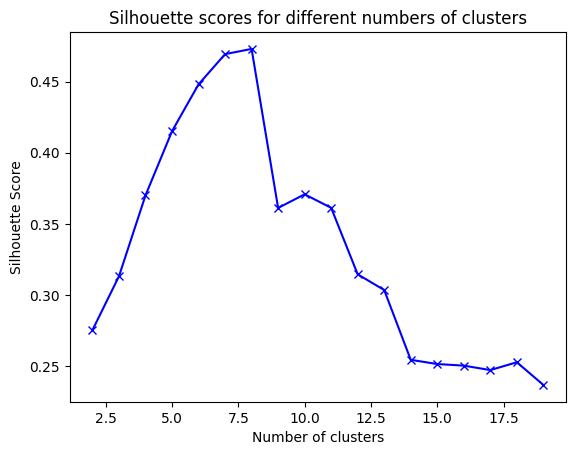

In [16]:
#First, determine the number of clusters via the silhouette scores
silhouette_avg = []
for i in range(2, 20):
    spectral_model_rbf = SpectralClustering(n_clusters=i)
    spectral_model_rbf.fit(unfiltered_inputs)
    spectral_model_rbf_labels = spectral_model_rbf.labels_

    silhouette_avg.append(silhouette_score(unfiltered_inputs, spectral_model_rbf_labels))

plt.plot(range(2, 20), silhouette_avg, 'bx-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette scores for different numbers of clusters")
plt.show()

In [17]:
#From the above plot, it looks like 7 clusters is optimal for rbf spectral clustering.
spectral_model_rbf = SpectralClustering(n_clusters=7, affinity="rbf")
spectral_model_rbf.fit(unfiltered_inputs)

SpectralClustering(n_clusters=7)

<Axes: xlabel='Constant', ylabel='PPP_PnR_handler'>

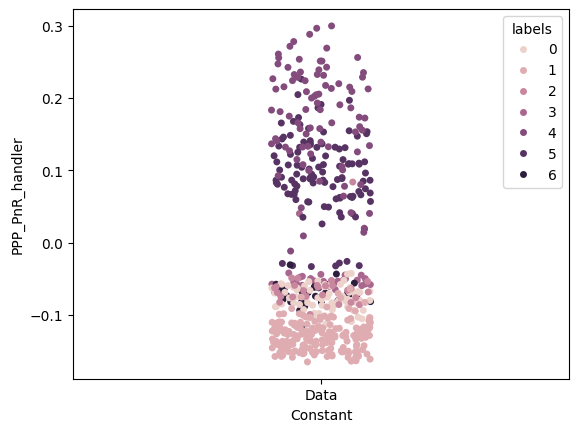

In [18]:
spectral_model_rbf_labels = pd.DataFrame(spectral_model_rbf.labels_)
filtered_output_rbf = pd.concat((unfiltered_inputs, spectral_model_rbf_labels), axis=1)
filtered_output_rbf = filtered_output_rbf.rename({0:"labels"},axis=1)
filtered_output_rbf["Constant"] = ["Data"]*len(filtered_output_rbf)
sns.stripplot(x=filtered_output_rbf['Constant'], y=filtered_output_rbf["PPP_PnR_handler"], hue=filtered_output_rbf['labels'], jitter=True)

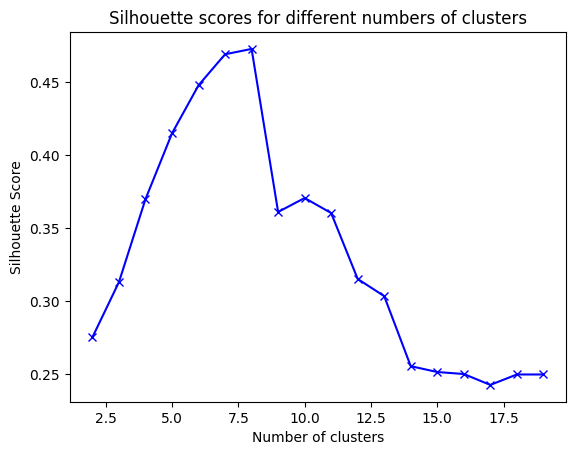

In [19]:
#That looks nice! Let's try nearest neighbor for affinity as well. First, we need to determine the # of clusters
silhouette_avg = []
for i in range(2, 20):
    spectral_model_nn = SpectralClustering(n_clusters=i)
    spectral_model_nn.fit(unfiltered_inputs)
    spectral_model_nn_labels = spectral_model_nn.labels_

    silhouette_avg.append(silhouette_score(unfiltered_inputs, spectral_model_nn_labels))

plt.plot(range(2, 20), silhouette_avg, 'bx-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette scores for different numbers of clusters")
plt.show()

In [20]:
#Optimal number of clusters is 7, so let's train with that.
spectral_clustering_nn = SpectralClustering(n_clusters=7, affinity="nearest_neighbors")
spectral_clustering_nn.fit(unfiltered_inputs)

/Users/nehalchigurupati/miniconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


SpectralClustering(affinity='nearest_neighbors', n_clusters=7)

<Axes: xlabel='Constant', ylabel='PPP_PnR_handler'>

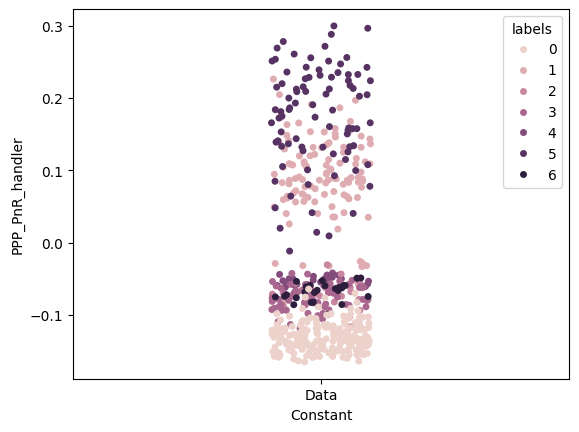

In [21]:
spectral_clustering_nn_labels = pd.DataFrame(spectral_clustering_nn.labels_)
filtered_output_nn = pd.concat((unfiltered_inputs, spectral_clustering_nn_labels), axis=1)
filtered_output_nn = filtered_output_nn.rename({0:"labels"},axis=1)
filtered_output_nn["Constant"] = ["Data"]*len(filtered_output_nn)
sns.stripplot(x=filtered_output_nn['Constant'], y=filtered_output_nn["PPP_PnR_handler"], hue=filtered_output_nn['labels'], jitter=True)

In [22]:
"""
Okay, so now we need to decide between our three techniques: kmeans, rbf spectral clustering, and nearest neighbor spectral clustering.
Let's start by computing silhouette scores.
"""

"\nOkay, so now we need to decide between our three techniques: kmeans, rbf spectral clustering, and nearest neighbor spectral clustering.\nLet's start by computing silhouette scores.\n"

In [23]:
print(silhouette_score(unfiltered_inputs, filtered_output["labels"]))
print(silhouette_score(unfiltered_inputs, spectral_model_rbf.labels_))
print(silhouette_score(unfiltered_inputs, spectral_clustering_nn.labels_))

0.466650582591949
0.46934477246600004
0.46984838303899107


In [24]:
#All of these are very similar. Let's try computing the Davies Bouldin score
print(davies_bouldin_score(unfiltered_inputs, filtered_output["labels"]))
print(davies_bouldin_score(unfiltered_inputs, spectral_model_rbf.labels_))
print(davies_bouldin_score(unfiltered_inputs, spectral_clustering_nn.labels_))


1.0231635137108273
0.9615607233889303
0.9569942298393693


In [25]:
#Let's go with the nearest neighbor method for getting the affinity matrix. The next step is visualization in 2-space. 

In [26]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(filtered_output_nn.drop(columns=["Constant", "labels"]))
pca_one = pca_result[:,0]
pca_two = pca_result[:,1]

/var/folders/wt/9_6pdt8n2kz5f1cv6bqysq440000gn/T/ipykernel_63689/3099959997.py:1: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(


<Axes: >

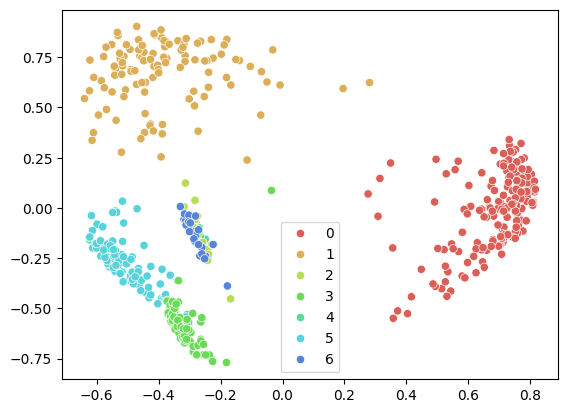

In [27]:
sns.scatterplot(
    x=pca_one,
    y=pca_two,
    palette=sns.color_palette("hls", 10),
    legend="full",
    hue=spectral_clustering_nn.labels_
)

In [28]:
"""
Let's think about what the graph above is telling US. PCA is taking the data and projecting it into the 2-space where the x and y components
explain the most variance of the data. We're then overlaying the clusters identified by spectral clustering by coloring the data points.
The fact that the clusters are well delineated in the PCA plot indicates that we have a good set of labels. 

The next step, then, is to take this all back to basketball, and think about what type of player each cluster describes.
"""

"\nLet's think about what the graph above is telling US. PCA is taking the data and projecting it into the 2-space where the x and y components\nexplain the most variance of the data. We're then overlaying the clusters identified by spectral clustering by coloring the data points.\nThe fact that the clusters are well delineated in the PCA plot indicates that we have a good set of labels. \n\nThe next step, then, is to take this all back to basketball, and think about what type of player each cluster describes.\n"

In [37]:
#First, we'll add back player names.
output = pd.concat((filtered_output_nn, player_names), axis=1)
output.rename(columns={"PLAYER_isolation": "PLAYER"})

,GP_isolation,POSS_isolation,FREQ%_isolation,PPP_isolation,PTS_isolation,FGM_isolation,FGA_isolation,FG%_isolation,EFG%_isolation,FT_isolation,...,EFG%_spot_up,FT_spot_up,TOV_spot_up,SF_spot_up,AND ONE_spot_up,SCORE_spot_up,PERCENTILE_spot_up,labels,Constant,PLAYER
0,0.086455,0.274647,0.192864,0.105408,0.314801,0.289650,0.278576,0.091386,0.108445,0.074531,...,0.037146,0.119403,-0.008011,0.129740,0.120738,0.052229,0.050523,1,Data,Luka Doncic
1,0.090029,0.225255,0.188798,0.110916,0.262660,0.275092,0.243635,0.100721,0.112005,0.051927,...,0.058151,0.067125,0.066144,0.074096,0.026029,0.054815,0.068102,1,Data,Jayson Tatum
2,0.103028,0.241735,0.198834,0.136139,0.295256,0.269260,0.238935,0.116420,0.117074,0.149991,...,0.034848,0.058285,0.025615,0.041323,-0.022074,0.061264,0.024450,1,Data,Shai Gilgeous-Alexander
3,0.075602,0.219233,0.164261,0.073851,0.198406,0.199529,0.213733,0.073039,0.069106,0.070374,...,0.057096,0.053533,0.000034,0.042797,-0.017335,0.059806,0.079443,1,Data,Kevin Durant
4,0.065760,0.165805,0.112333,0.089383,0.189521,0.197813,0.160887,0.095296,0.088727,0.095600,...,0.042235,0.075493,0.061088,0.061326,-0.016217,0.052003,0.047937,1,Data,Joel Embiid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,-0.107967,-0.086350,-0.096873,-0.103653,-0.080774,-0.081762,-0.086184,-0.102374,-0.102431,-0.088574,...,0.028045,-0.146246,0.303951,-0.143663,-0.093929,0.082006,-0.166463,0,Data,NaN
542,-0.105350,-0.084257,-0.094525,-0.101141,-0.078816,-0.079781,-0.084095,-0.099893,-0.099949,-0.086427,...,-0.072661,0.324070,-0.145812,0.357534,-0.091653,0.052649,-0.168773,0,Data,NaN
543,-0.110426,-0.088317,-0.099080,-0.106015,-0.082614,-0.083625,-0.088148,-0.104707,-0.104765,-0.090592,...,0.002670,-0.149578,0.269141,-0.146936,-0.096069,-0.041502,-0.176906,0,Data,NaN
544,-0.103961,-0.083147,-0.093279,-0.099808,-0.077777,-0.078729,-0.082987,-0.098576,-0.098631,-0.085288,...,-0.051665,-0.140821,0.218459,-0.138333,-0.090445,-0.054077,-0.170305,0,Data,NaN


<Axes: xlabel='Constant', ylabel='PPP_isolation'>

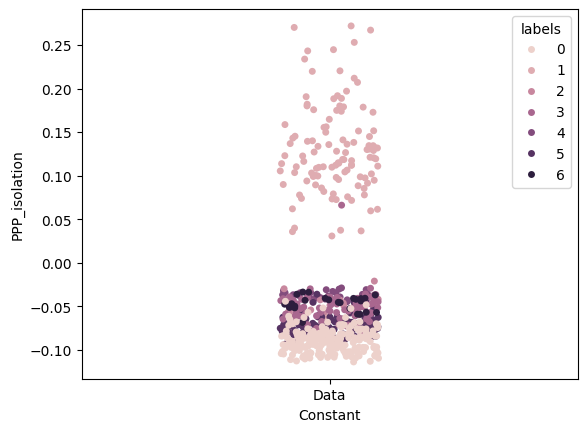

In [39]:
#Let's see what each cluster attempts the most, using ppp for each given play type
output["Constant"] = ["Data"] * len(output)
sns.stripplot(x=output['Constant'], y=output["PPP_isolation"], hue=output['labels'], jitter=True)